In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kagglehub
import os
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## 1. Dowload dataset and EDA

In [2]:
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
os.listdir(path)

['amazon_review_polarity_csv.tgz', 'test.csv', 'train.csv']

In [3]:
train_df = pd.read_csv(f"{path}\\train.csv",header=None)
test_df = pd.read_csv(f"{path}\\test.csv",header=None)

In [4]:
train_df.head()

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
test_df.head()

,0,1,2
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
print("Train size: ", train_df.shape)
print("Test size: ", test_df.shape)

Train size:  (3600000, 3)
Test size:  (400000, 3)


In [7]:
# Rename columns

train_df.columns = ["label", "title", "review"]
test_df.columns = ["label", "title", "review"]

In [8]:
# Rename labels:
# 1 becomes 0, negative review
# 2 becomes 1, positive review

train_df["label"] = train_df["label"] - 1
test_df["label"] = test_df["label"] - 1

In [9]:
# Check if there are imbalances

train_df["label"].value_counts()

label
1    1800000
0    1800000
Name: count, dtype: int64

The dataset is perfectly balanced.

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   title   object
 2   review  object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [11]:
# Check if there are missing values

print(train_df.isnull().sum())
print(test_df.isnull().sum())

label       0
title     207
review      0
dtype: int64
label      0
title     24
review     0
dtype: int64


In [12]:
# I fill the Null values; When title misses, only review will be used

train_df["title"] = train_df["title"].fillna("")
test_df["title"] = test_df["title"].fillna("")

print(train_df.isnull().sum())
print(test_df.isnull().sum())

label     0
title     0
review    0
dtype: int64
label     0
title     0
review    0
dtype: int64


Since the dataset is to big and training the model would require too much for my laptop, I select a subset of data. 

When extracting the subset, I want to preserve the balance in the labels 0 and 1.

In [13]:
# Train subset

n_train_per_class = 100000

train_neg = train_df[train_df["label"] == 0].sample(n_train_per_class, random_state=42)
train_pos = train_df[train_df["label"] == 1].sample(n_train_per_class, random_state=42)

train_df_balanced = pd.concat([train_neg, train_pos]).sample(frac=1, random_state=42)

In [14]:
# Test subset

n_test_per_class = 25000

test_neg = test_df[test_df["label"] == 0].sample(n_test_per_class, random_state=42)
test_pos = test_df[test_df["label"] == 1].sample(n_test_per_class, random_state=42)

test_df_balanced = pd.concat([test_neg, test_pos]).sample(frac=1, random_state=42)

In [15]:
print(train_df_balanced["label"].value_counts())
print(test_df_balanced["label"].value_counts())

label
1    100000
0    100000
Name: count, dtype: int64
label
1    25000
0    25000
Name: count, dtype: int64


## 2. Text pre-processing

* Lowercasing
* Remove special characters
* Choice of vocabulary size
* Tokenization
* Choice of sentence length
* Padding

I will use both the title and the review for training.

In [16]:
train_df_balanced["text"] = (train_df_balanced["title"] + " " + train_df_balanced["review"])
test_df_balanced["text"] = (test_df_balanced["title"] + " " + test_df_balanced["review"])

In [17]:
# Function to clean the text

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # only letters, punctuation and space
    text = re.sub(r"\s+", " ", text)  # remove multiple spaces
    return text.strip()

train_df_balanced["text"] = train_df_balanced["text"].astype(str)
test_df_balanced["text"] = test_df_balanced["text"].astype(str)

train_df_balanced["text"] = train_df_balanced["text"].apply(clean_text)    
test_df_balanced["text"] = test_df_balanced["text"].apply(clean_text)    

In [18]:
# check

print(len(train_df_balanced["text"].iloc[0].split()))
train_df_balanced["text"].iloc[0]

66


'what you would expect from johanna lindsey i have been a lindsey fan for twenty years and this book is exactly what i was expecting a nice update on tedra de arr a plot that skips along nicely smutty sex scenes with a strongwilled guy and a passionate heroine the ending did wrap up quickly but overall it was a good fluffy read that i enjoyed'

In [19]:
# Choice of vocabulary size
# Count all unique words, order by frequency, check how many words to cover 90% of the corpus

all_words = []

for text in train_df_balanced["text"]:
    all_words.extend(text.split())

word_counts = Counter(all_words)
total_words = sum(word_counts.values())
unique_words = len(word_counts)

print("Total words: ", total_words)
print("Unique words: ", unique_words)

Total words:  15504912
Unique words:  286132


In [20]:
cumulative = 0

for i, (word, count) in enumerate(word_counts.most_common()):
    cumulative += count
    if cumulative / total_words >= 0.9:
        print("Words needed for 90% coverage: ", i)
        break

Words needed for 90% coverage:  4534


In [21]:
# I choose a slightly larger vocabulary size

voc_size = 8000

In [22]:
# Tokenization

tokenizer = Tokenizer(num_words=voc_size, oov_token="<OOV>")  # 1 index = OOV (Out Of Vocabulary)
tokenizer.fit_on_texts(train_df_balanced["text"])

X_train_seq = tokenizer.texts_to_sequences(train_df_balanced["text"])
X_test_seq = tokenizer.texts_to_sequences(test_df_balanced["text"])

In [23]:
print(len(X_train_seq[0]))
X_train_seq[0]

66


[46,
 16,
 40,
 554,
 37,
 1,
 1,
 4,
 21,
 86,
 5,
 1,
 215,
 12,
 2879,
 138,
 3,
 9,
 20,
 10,
 590,
 46,
 4,
 14,
 849,
 5,
 184,
 1964,
 19,
 1,
 852,
 1,
 5,
 300,
 13,
 5335,
 422,
 1336,
 1,
 861,
 609,
 17,
 5,
 1,
 558,
 3,
 5,
 4407,
 2178,
 2,
 546,
 100,
 2817,
 55,
 556,
 18,
 448,
 8,
 14,
 5,
 33,
 5726,
 52,
 13,
 4,
 346]

In [24]:
# Choice of sentence length

lengths = [len(seq) for seq in X_train_seq]

print("Mean: ", np.mean(lengths))
print("Median: ", np.median(lengths))
print("90%: ", np.percentile(lengths, 90))
print("95%: ", np.percentile(lengths, 95))
print("99%: ", np.percentile(lengths, 99))
print("Max: ", np.max(lengths))

Mean:  77.52456
Median:  69.0
90%:  142.0
95%:  159.0
99%:  179.0
Max:  213


In [25]:
# A good compromise

max_length = 150

In [26]:
# Padding

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

y_train = train_df_balanced["label"].values
y_test = test_df_balanced["label"].values

In [27]:
# Check

print(X_train_pad.shape)
print(X_test_pad.shape)

(200000, 150)
(50000, 150)


## 3. Model

In [28]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, input_shape=(max_length,), mask_zero=True))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 100)            │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,377 (3.50 MB)

 Trainable params: 917,377 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train

history = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=128)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 114s 80ms/step - accuracy: 0.8816 - loss: 0.2930 - val_accuracy: 0.9065 - val_loss: 0.2407
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.9260 - loss: 0.1933 - val_accuracy: 0.9178 - val_loss: 0.2099
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 109s 77ms/step - accuracy: 0.9397 - loss: 0.1611 - val_accuracy: 0.9232 - val_loss: 0.2115
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 76ms/step - accuracy: 0.9492 - loss: 0.1377 - val_accuracy: 0.9209 - val_loss: 0.2043
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 77ms/step - accuracy: 0.9579 - loss: 0.1176 - val_accuracy: 0.9201 - val_loss: 0.2198
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 77ms/step - accuracy: 0.9652 - loss: 0.1002 - val_accuracy: 0.9175 - val_loss: 0.2375
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 77ms/step - accuracy: 0.9711 - loss: 0.0843 - val_accuracy: 0.9180 - val_loss: 0.2722
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 76ms/step - accuracy: 

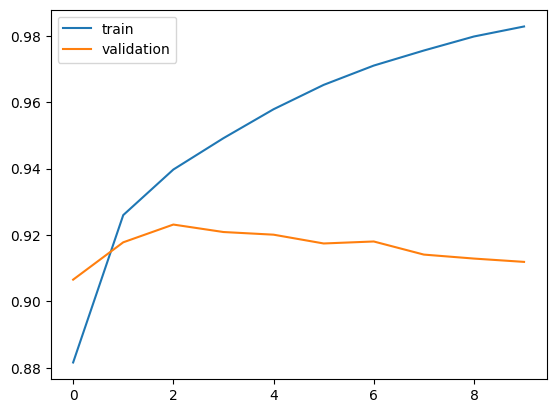

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [31]:
# Evaluate

y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification report: \n", classification_report(y_test, y_pred))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
Accuracy:  0.91362
Confusion matrix: 
 [[22998  2002]
 [ 2317 22683]]
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91     25000
           1       0.92      0.91      0.91     25000

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



The best model is between epochs 3 and 5 for the baseline model.

## 4. Model using GloVe (frozen)

In [34]:
# Open GloVe

embedding_index = {} 

with open("C:\\Users\\Chiara\\Desktop\\LEARN\\glove.6B\\glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

print("Total words in GloVe: ", len(embedding_index))

Total words in GloVe:  400000


In [35]:
# Initialize embedding matrix

embedding_matrix = np.zeros((voc_size, embedding_dim))

In [36]:
# I connect my tokenizer to GloVe

for word, i in tokenizer.word_index.items():
    if i >= voc_size:
        continue

    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [37]:
# Check

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("Words covered by GloVe: ", nonzero_elements)
print("Coverage: ", nonzero_elements / voc_size)

Words covered by GloVe:  7924
Coverage:  0.9905


In [38]:
# Model

model_glove = Sequential()
model_glove.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights=[embedding_matrix], input_shape=(max_length,), trainable=False, mask_zero=True))
model_glove.add(LSTM(128))
model_glove.add(Dropout(0.3))
model_glove.add(Dense(1, activation="sigmoid"))

model_glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_glove.summary()

C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 100)            │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,377 (3.50 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 800,000 (3.05 MB)

In [41]:
# Training 

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history_glove = model_glove.fit(X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=128, callbacks=[early_stop])

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 74ms/step - accuracy: 0.8193 - loss: 0.3950 - val_accuracy: 0.8744 - val_loss: 0.2974
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 105s 74ms/step - accuracy: 0.8910 - loss: 0.2647 - val_accuracy: 0.8982 - val_loss: 0.2481
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.9056 - loss: 0.2328 - val_accuracy: 0.9061 - val_loss: 0.2339
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.9159 - loss: 0.2107 - val_accuracy: 0.9143 - val_loss: 0.2154
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.9228 - loss: 0.1954 - val_accuracy: 0.9167 - val_loss: 0.2144
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 103s 74ms/step - accuracy: 0.9293 - loss: 0.1812 - val_accuracy: 0.9194 - val_loss: 0.2022
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 102s 72ms/step - accuracy: 0.9344 - loss: 0.1688 - val_accuracy: 0.9182 - val_loss: 0.2039
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 

In [42]:
# Evaluate

y_pred_glove = model_glove.predict(X_test_pad)
y_pred_glove = (y_pred_glove > 0.5).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred_glove))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_glove))
print("Classification report: \n", classification_report(y_test, y_pred_glove))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
Accuracy:  0.92068
Confusion matrix: 
 [[23076  1924]
 [ 2042 22958]]
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     25000
           1       0.92      0.92      0.92     25000

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000



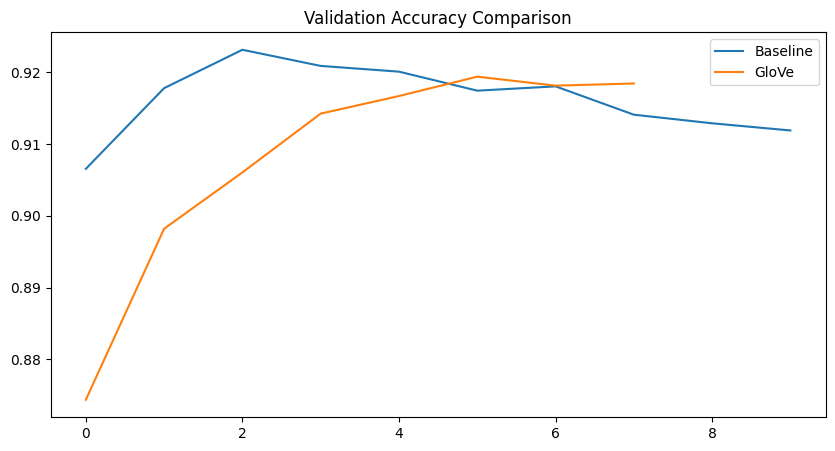

In [43]:
# Comparison

plt.figure(figsize=(10,5))

plt.plot(history.history['val_accuracy'], label="Baseline")
plt.plot(history_glove.history['val_accuracy'], label="GloVe")

plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()

## 5. Fine-tuned GloVe

In [44]:
model_glove_ft = Sequential()
model_glove_ft.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights=[embedding_matrix], input_shape=(max_length,), trainable=True, mask_zero=True))
model_glove_ft.add(LSTM(128))
model_glove_ft.add(Dropout(0.3))
model_glove_ft.add(Dense(1, activation="sigmoid"))

model_glove_ft.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_glove_ft.summary()

C:\Users\Chiara\anaconda3\envs\cv\lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 150, 100)            │         800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 917,377 (3.50 MB)

 Trainable params: 917,377 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Training 

early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
history_glove_ft = model_glove_ft.fit(X_train_pad, y_train, validation_split=0.1, epochs=10, batch_size=128, callbacks=[early_stop])

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - accuracy: 0.8722 - loss: 0.2977 - val_accuracy: 0.9100 - val_loss: 0.2273
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.9268 - loss: 0.1898 - val_accuracy: 0.9226 - val_loss: 0.1947
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.9389 - loss: 0.1611 - val_accuracy: 0.9253 - val_loss: 0.1912
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 106s 76ms/step - accuracy: 0.9479 - loss: 0.1393 - val_accuracy: 0.9236 - val_loss: 0.1932
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - accuracy: 0.9565 - loss: 0.1195 - val_accuracy: 0.9272 - val_loss: 0.1989


In [46]:
# Evaluate

y_pred_glove_ft = model_glove_ft.predict(X_test_pad)
y_pred_glove_ft = (y_pred_glove_ft > 0.5).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred_glove_ft))
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_glove_ft))
print("Classification report: \n", classification_report(y_test, y_pred_glove_ft))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step
Accuracy:  0.92722
Confusion matrix: 
 [[22908  2092]
 [ 1547 23453]]
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     25000
           1       0.92      0.94      0.93     25000

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



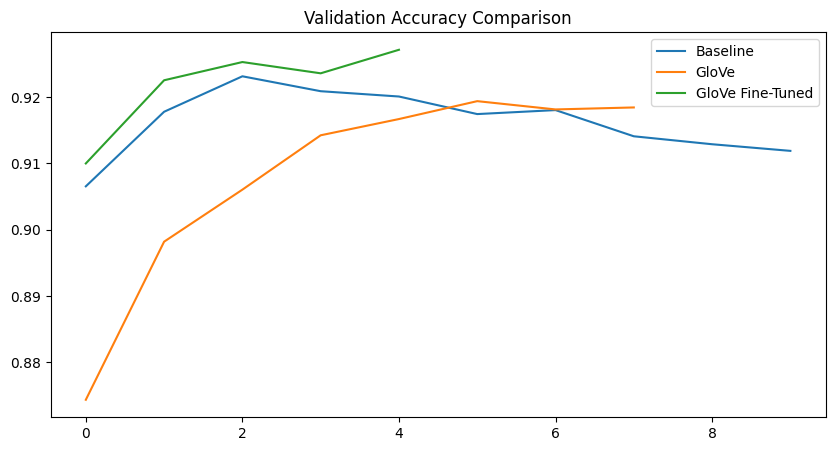

In [47]:
# Comparison

plt.figure(figsize=(10,5))

plt.plot(history.history['val_accuracy'], label="Baseline")
plt.plot(history_glove.history['val_accuracy'], label="GloVe")
plt.plot(history_glove_ft.history['val_accuracy'], label="GloVe Fine-Tuned")

plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()

## 6. Comparison

In [49]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred)
    }

    return metrics

In [53]:
baseline_metrics = evaluate_model(model, X_test_pad, y_test)
glove_metrics = evaluate_model(model_glove, X_test_pad, y_test)
glove_ft_metrics = evaluate_model(model_glove_ft, X_test_pad, y_test)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step


In [54]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline", "GloVe Frozen", "GloVe Fine-Tuned"],
    "Accuracy": [
        baseline_metrics["accuracy"],
        glove_metrics["accuracy"],
        glove_ft_metrics["accuracy"]
    ],     
    "Precision": [
        baseline_metrics["precision"],
        glove_metrics["precision"],
        glove_ft_metrics["precision"]
    ],
    "Recall": [
        baseline_metrics["recall"],
        glove_metrics["recall"],
        glove_ft_metrics["recall"]
    ],
    "F1-score": [
        baseline_metrics["f1"],
        glove_metrics["f1"],
        glove_ft_metrics["f1"]
    ]
})

comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline,0.91362,0.918898,0.90732,0.913072
1,GloVe Frozen,0.92068,0.922675,0.91832,0.920492
2,GloVe Fine-Tuned,0.92722,0.918105,0.93812,0.928005
